# Titanic


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from importlib import reload
import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
import optuna
import pickle

from modules import function


In [11]:
# Get raw data
train_data_raw = pd.read_csv("../data/raw/train.csv")
test_data_raw = pd.read_csv("../data/raw/test.csv")

# Extract used features
use_columns = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "Embarked"]
y_train = train_data_raw["Survived"]
train_data = train_data_raw[use_columns]
test_data = test_data_raw[use_columns]

# Make one hot features of Sex and Embarked
for column_name in ["Sex", "Embarked"]:
    train_data = function.add_one_hot(train_data, column_name)
    test_data = function.add_one_hot(test_data, column_name)
    
# Replace nan to mean of the column
train_data = function.nan_to_mean(train_data)
test_data = function.nan_to_mean(test_data)


x_train = train_data
x_test = test_data
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

x_train2, x_test2, y_train2, y_test2=train_test_split(x_train, y_train, test_size=0.05, shuffle=True, random_state=42)


In [12]:
# Fit data using LightGBM
lgbm_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'accuracy',
            'num_leaves': 12,
            "max_depth": 6,
            'learning_rate': 0.054,
            'n_estimators': 10000,
            'random_state': 42,
            "class_weight": "balanced"
        }
eval_metric = "logloss"
stopping_rounds = 50


clf = lgb.LGBMClassifier(**lgbm_params)
clf = function.lgbm_fit_earlystopping(clf, x_train2, y_train2, x_test2, y_test2, eval_metric="logloss", stopping_rounds=50)

# Predict
y_pred=clf.predict(x_test)
y_pred2 = clf.predict(x_test2)

print("Acc2 :", accuracy_score(y_pred2, y_test2))

Acc2 : 0.8222222222222222


In [140]:
# Save prediction
PassengerId = np.array(test_data_raw["PassengerId"]).astype(int)
function.save_kaggle_prediction(y_pred, PassengerId, "Survived", "PassengerId")


<Axes: >

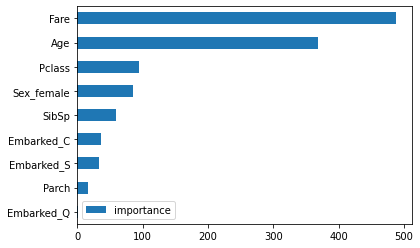

In [141]:
fi = clf.feature_importances_
fi = pd.DataFrame(fi, 
                 index=train_data.columns,
                 columns=["importance"])

fi = fi.sort_values("importance", ascending=True)
fi.plot.barh()

In [152]:
params={"num_leaves":[2,30],"learning_rate":[0.01,0.2],"max_depth":[1,10]}

n_splits = 3
cv = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=42)



function.lgbm_bayesian_opt(x_train2, y_train2, cv, params=params, n_trials=10, config="print")

trial: 8
0.8333518969718066
{'num_leaves': 25, 'max_depth': 5, 'learning_rate': 0.15830054349442654}
1 : 0.8274416985729204 {'num_leaves': 17, 'max_depth': 8, 'learning_rate': 0.12452504145361233}
2 : 0.820341106856944 {'num_leaves': 17, 'max_depth': 5, 'learning_rate': 0.13271988148266467}
3 : 0.8250539505743125 {'num_leaves': 14, 'max_depth': 9, 'learning_rate': 0.19309592449519558}
4 : 0.8227079707622694 {'num_leaves': 13, 'max_depth': 8, 'learning_rate': 0.11049003475305184}
5 : 0.822701009397842 {'num_leaves': 18, 'max_depth': 10, 'learning_rate': 0.02349685105759852}
6 : 0.7884371736860425 {'num_leaves': 4, 'max_depth': 1, 'learning_rate': 0.16819777065410824}
7 : 0.8309780717020535 {'num_leaves': 24, 'max_depth': 9, 'learning_rate': 0.19593748502422517}
8 : 0.8333518969718066 {'num_leaves': 25, 'max_depth': 5, 'learning_rate': 0.15830054349442654}
9 : 0.8097111033762617 {'num_leaves': 5, 'max_depth': 7, 'learning_rate': 0.037237124607718816}
10 : 0.8262582666202576 {'num_leaves'

In [173]:

n_splits = 5
cv_cv = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=42)

cv_opt = StratifiedKFold(
        n_splits=3, shuffle=True, random_state=42)


study_list = function.cv_lgbm_bayesian_opt(x_train, y_train, cv_cv, cv_opt, params, n_trials=100)

In [174]:

with open("../data/processed/study_list_"+function.get_now_time()+".bin", 'wb') as p:
    pickle.dump(study_list, p)
  


In [31]:
with open("../data/processed/study_list_20230525_154947.bin", 'rb') as p:
    study_list = pickle.load(p)

best_pramas_list = []
for study in study_list:
    best_pramas_list.append(study.best_params)
print(best_pramas_list)

[{'num_leaves': 23, 'max_depth': 2, 'learning_rate': 0.046977005798683774}, {'num_leaves': 26, 'max_depth': 2, 'learning_rate': 0.029971710973680364}, {'num_leaves': 9, 'max_depth': 2, 'learning_rate': 0.10966529992688127}, {'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.1308455934899561}, {'num_leaves': 21, 'max_depth': 10, 'learning_rate': 0.050864369455988226}]


In [33]:
x = x_train2
y = y_train2

n_splits = 5
cv_cv = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=42)



In [36]:
clf_list = function.cv_lgbm_clf(x_train2, y_train2, cv_cv, best_pramas_list, eval_metric="logloss", stopping_rounds=50)

with open("../models/clf_list_"+function.get_now_time()+".bin", 'wb') as p:
    pickle.dump(study_list, p)
  

In [37]:
with open("../models/clf_list_20230526_153836.bin", 'rb') as p:
    clf_list = pickle.load(p)

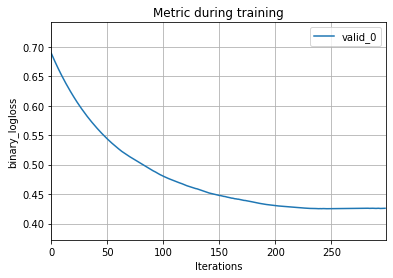

In [94]:
lgb.plot_metric(clf)
plt.show()

In [ ]:


x_label = "Age"
y_label = "Fare"
fig, ax = plt.subplots(figsize=(10,6))
scatter = ax.scatter(train_data_raw[x_label], train_data_raw[y_label], c=train_data_raw["Survived"], cmap='viridis')

# 軸ラベルの設定
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

# 凡例の表示
legend_labels = ['Dead', 'Survived']
ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Labels')
